# Importação das bibliotecas

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import time

## Variaveis e caminhos

In [2]:
idImagem = "1"
fruta    = "limao"

IMAGEM_CAPTURADA_SEGMENTADA = "caixas"            + idImagem + ".jpg"
IMAGEM_CAPTURADA_NORMAL =     "normal"            + idImagem + ".jpg"
IMAGEM_CORTADA_PEDUNCULO =    "pedunculoCortado"  + idImagem + ".png"
PEDUNCULO_HSV =               "pedunculoHSV"      + idImagem + ".png"
PEDUNCULO_BGR =               "pedunculoBGR"      + idImagem + ".png"

### Mostra imagem

In [3]:
def mostraImagem(imagemUso, titulo):

    fig = plt.figure(figsize = (5, 8))
    plt.title(titulo)
    plt.imshow(imagemUso)
    plt.show()

## Calibração HSV

In [4]:
with open("Calibracao/calibracao_hsv_" + fruta + ".txt") as hsv:
    
    parametros = hsv.readlines()
          
    hMin = int(parametros[0])
    sMin = int(parametros[1])
    vMin = int(parametros[2])
        
    hMax = int(parametros[3])
    sMax = int(parametros[4])
    vMax = int(parametros[5])
    


# Imagem Pré-Processada

Encontra a região de corte - trabalha apenas com a fruta

In [5]:
imgPreProcessada = cv.imread(IMAGEM_CAPTURADA_SEGMENTADA) #Leitura da imagem de entrada, imagem deve ser pré-processada - Real Time Object Detection
gray = cv.cvtColor(imgPreProcessada, cv.COLOR_BGR2GRAY) #Converte a imagem para tons de cinza

In [6]:
todas_coordenadas = [] #Guarda as coordenadas do eixo X e Y vindas dos cantos encontrados

cornersPedunculo = cv.goodFeaturesToTrack(gray, 4, 0.6, 0.2) #Função responsavel por encontrar os cantos Harrys

for item in cornersPedunculo:
    
    x,y = item[0]
    
    todas_coordenadas.append([x,y])
    #cv.circle(imgPreProcessada, (int(x),int(y)), 4, (0,0,255))
    
#mostraImagem(imgPreProcessada, "CAIXA SEGMENTADA")

In [7]:
todas_coordenadas.sort() #Ordena as coordenadas em ordem crescente


#Ultiza-se apenas a primeira coordenada e a ultima
xt = todas_coordenadas[0][0]
yt = todas_coordenadas[0][1]

xb = todas_coordenadas[3][0]
yb = todas_coordenadas[3][1]

#print(xt, yt)
#print(xb, yb)


In [8]:
#Regiao de interesse

Lmax = abs(xt - xb)
Hmax = abs(yt - yb)

RoiL = 0.5 * Lmax
RoiH = 0.5 * Hmax

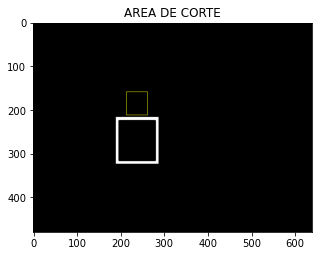

In [9]:
#Area de corte da imagem

#Esses coordenadas são as que vão delimitar a area onde a imagem vai ser cortada

centro = (xb + xt) / 2

centroCaixa = RoiL / 2

x1 = centro - centroCaixa
x2 = centro + centroCaixa

y1 = abs(yt - 5)
y2 = abs(RoiH - y1)

x1 = int(x1)
y1 = int(y1)
x2 = int(x2)
y2 = int(y2)

TopLeftY = y2
TopLeftX = x1

cv.rectangle(imgPreProcessada, (x2, y2), (x1,y1), (255,255,0), 1)

mostraImagem(imgPreProcessada, "AREA DE CORTE")


# Imagem Sem Processamento

Corte

In [10]:
img = cv.imread(IMAGEM_CAPTURADA_NORMAL) #Leitura da imagem de entrada, imagem deve ser sem processamento - Real Time Object Detection

In [11]:
crop = img[y2:y1, x1:x2] #Realiza o corte da imagem
cv.imwrite(IMAGEM_CORTADA_PEDUNCULO, crop) #Salva a imagem cortada

True

## Segmentação do pedúnculo

Primeira Segementação - HSV

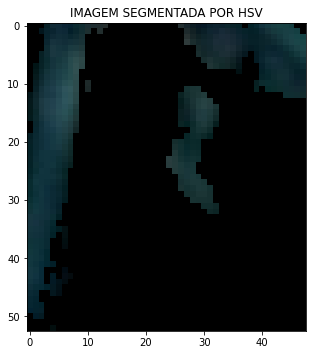

In [12]:
#Ultimo cenario de teste 
#baixo = np.array([5, 100, 18])
#alto = np.array([31, 248, 74])

#Teste anterior 
#baixo = np.array([[0, 30, 0]])
#alto = np.array([179, 255, 255])

#Para testes (editavel)
#baixo = np.array([10,53,61])
#alto = np.array([24,137,110])


#Padrão (sera usado com as leituras do txt)
baixo = np.array([[hMin, sMin, vMin]])
alto =  np.array([hMax, sMax, vMax])

imgPedunculo = [IMAGEM_CORTADA_PEDUNCULO]

for pedunculo in imgPedunculo:
    
    img = cv.imread(pedunculo)
    
    img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    
    mask = cv.inRange(img_hsv, baixo, alto)
    
    img_seg = cv.bitwise_and(img, img, mask = mask)
    
cv.imwrite(PEDUNCULO_HSV, img_seg)
    
mostraImagem(img_seg, "IMAGEM SEGMENTADA POR HSV")

Segunda Segmentação - BGR

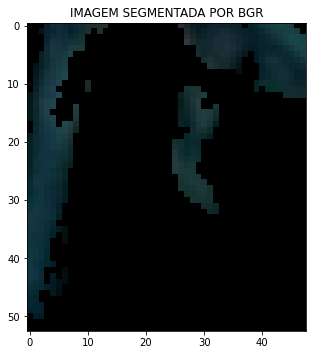

In [13]:
imgHSV = cv.imread(PEDUNCULO_HSV)

largura = imgHSV.shape[1]
altura  = imgHSV.shape[0]

imgBGR = cv.resize(imgHSV, (largura, altura))

height, width, canalCor = imgBGR.shape

base = [20,20,15]
fraca = [35,55,60]
forte = [70, 70, 100]
preto = [0, 0, 0]

for x in range(0, width):

    for y in range(0, height):

        canalXY = imgBGR[y,x]

        if all(canalXY <= base):

            imgBGR[y,x] = preto

        elif all(canalXY > fraca):

            imgBGR[y,x] = preto


cv.imwrite(PEDUNCULO_BGR, imgBGR)

mostraImagem(imgBGR, "IMAGEM SEGMENTADA POR BGR")
#print(largura, altura)

## Encontra ponto - trabalhar apenas com o pedúnculo

In [14]:
imgSegBGR = cv.imread(PEDUNCULO_BGR) #Leitura da imagem de entrada, imagem encontrada anteriormente - imagem cortada
gray = cv.cvtColor(imgSegBGR, cv.COLOR_BGR2GRAY) #Converte a imagem para tons de cinza

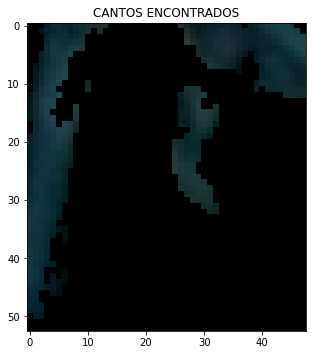

In [15]:
todas_coordenadas = [] 
todas_coordenadasX = [] #Guarda as coordenadas do eixo X vindas dos cantos encontrados
todas_coordenadasY = [] #Guarda as coordenadas do eixo Y vindas dos cantos encontrados

cornersPonto = cv.goodFeaturesToTrack(gray, 20, 0.2, 0.25) #Função responsavel por encontrar os cantos Harrys

for item in cornersPonto:
    
    x,y = item[0]
    
    todas_coordenadas.append((x,y))
    todas_coordenadasX.append(int(x))
    todas_coordenadasY.append(int(y))
    #cv.circle(imgSegBGR, (int(x),int(y)), 1, (0,0,255))
    
mostraImagem(imgSegBGR, "CANTOS ENCONTRADOS")

In [16]:
qtdBusca = np.sqrt(len(todas_coordenadas))

qtdBusca = round(qtdBusca)

## Função encontra ponto de partida

In [17]:
#Funções

#Calcula o peso das coordenadas

def calculaPesoY(a):
    
    calPeso = (a[0] * a[0]) + (a[1] * a[1])
    
    calPeso = np.sqrt(calPeso)
    
    calPeso = int(calPeso)
    
    return calPeso

def calculaPesoX(a, centro):
    
    if(a[0] > centro):
        
        dif = (centro - a[0])
        
        soma = a[0] + dif
        
    else:
        
        soma = a[0]
        
    calPeso = (soma * soma) + (a[1] * a[1])
    
    calPeso = np.sqrt(calPeso)
    
    calPeso = round(calPeso)
    
    return calPeso



#Faz a combinação entre a coordenadas e os pesos

def combinacao(peso: list, todas_coordenadasN: list) -> list:
    
    assert len(peso) == len(todas_coordenadasN)
 
    n = len(peso)
    
    combi = []
 
    for i in range(n):
        
        combi.append((peso[i], todas_coordenadasN[i]))
         
    return combi

#Calcula a media dos pontos

def calculaMedia(m):
    
    calMedia = (m[0] *  m[1])
    
    calMedia = int(calMedia)
    
    return calMedia

In [18]:
pesoY = []
pesoX = []
mediaX = []
mediaY = []
centro = imgBGR.shape[0] / 2
margem = imgBGR.shape[1] - 5
centroY = imgBGR.shape[1] / 2

centroY = int(centroY)

centro = int(centro)
print(centro)
#Calcula o peso de Y
for i in todas_coordenadas:
    
    aux = calculaPesoY(i)
    
    pesoY.append(aux)
    
#Calcula o peso de X
for i in todas_coordenadas:
    
    aux = calculaPesoX(i, centro)
    
    pesoX.append(aux)
    
#Somatorio do peso Y
somatorioPesoY = sum(pesoY)

#Somatoria do pedo X
somatorioPesoX = sum(pesoX)
    
#Realiza combinação
combinacaoX = combinacao(pesoX, todas_coordenadasX)
combinacaoY = combinacao(pesoY, todas_coordenadasY)

#Calcula a media dos pontos X
for i in combinacaoX:
    
    aux = calculaMedia(i)
    
    mediaX.append(aux)
    
#Calcula a media dos pontos Y
for i in combinacaoY:
    
    aux = calculaMedia(i)
    
    mediaY.append(aux)


somatorioX =  sum(mediaX)
somatorioY =  sum(mediaY)

pontoX = (somatorioX / somatorioPesoX)  
pontoY = (somatorioY / somatorioPesoY)

pontoX = int(pontoX)
pontoY = int(pontoY)

26


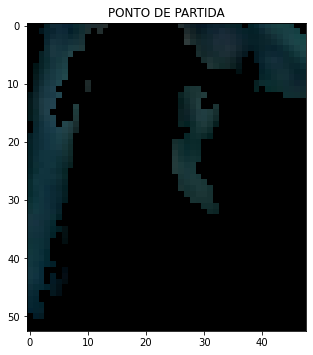

In [19]:
pontoPartida = (pontoX, pontoY)
#cv.circle(imgSegBGR, (pontoX, pontoY), 1, (0,255,0))
    
mostraImagem(imgSegBGR, "PONTO DE PARTIDA")

# Buscas

In [20]:
#Funcao que verifica o RGB de cada pixel
pend = [9, 30, 32]
fora = [40, 40, 40]

def marca_ponto(ponto_y, ponto_x):
    
    controle = 0
    
    #Verifica se os valores de um determinado pixel é maior que o RGB(100, 120, 40)
    
    if np.any(imgSegBGR[int(ponto_y), int(ponto_x)] >= pend):
        
        if np.any(imgSegBGR[int(ponto_y), int(ponto_x)] < fora):
             
            controle = 1        
    else:
        
        controle = 0
        
    return controle

### Primeira busca

In [21]:
def primeiraMovimentacao(pontoY, pontoX, limiteY, limiteX):
    
    #Ponto maximo dos cantos encontrados 
    pontoMaximoX = max(todas_coordenadasX)
    pontoMaximoY = max(todas_coordenadasY)
    
    contaBusca = 0
    
    while(True):
    
        coordenada = marca_ponto(round(pontoY), round(pontoX))

        if(coordenada == 1):

            pontoY, pontoX = pontoY, pontoX
          
            return pontoY, pontoX, contaBusca  
        
        elif(pontoX > centro):
        
            pontoY, pontoX = pontoY, centro
        
        elif(pontoY >= margem):
        
            pontoY = centroY

        else:

            if(pontoX >= centro):

                pontoY, pontoX = pontoY + 1, pontoX - contaBusca

            else:

                pontoY, pontoX = pontoY + 1, pontoX + contaBusca
                
        contaBusca = contaBusca + 1
    

In [22]:
def segundaMovimentacao(pontoY, pontoX, limiteY): #Movimentação para baixo
    
    pontoY = pontoY + 5
    contaBusca = 0
    
    while(True):
    
        coordenada = marca_ponto(round(pontoY), round(pontoX))

        if(coordenada == 1):

            pontoY, pontoX = pontoY, pontoX

            return pontoY, pontoX, contaBusca  
        
        elif(pontoY >= margem):
        
            pontoY = centroY

        else:

            pontoY, pontoX = pontoY + 1, pontoX

        contaBusca = contaBusca + 1
    

In [23]:
def terceiraMovimentacao(pontoY, pontoX): #Movimentação para cima
    
    pontoY = pontoY - 5
    contaBusca = 0
    
    while(True):
    
        coordenada = marca_ponto(round(pontoY), round(pontoX))

        if(coordenada == 1):

            pontoY, pontoX = pontoY, pontoX

            return pontoY, pontoX, contaBusca  
        else:

            pontoY, pontoX = pontoY - 1, pontoX

        contaBusca = contaBusca + 1

## Cálculo da diferença de cores 

In [24]:
def difEuclidiana(cores):
    
    euclidiana = (cores[0] - cores[1])
    
    Eucli = euclidiana * euclidiana
    
    return Eucli

In [25]:
def calculaEuclidiana(combinacoes):
    
    Euclidiana = 0
    
    for i in combinacoes:
        
        Euclidiana = Euclidiana + difEuclidiana(i)

        raizEuclidiana = np.sqrt(Euclidiana)
        
    return raizEuclidiana   

### Distância Euclidiana

In [26]:
busca1 = primeiraMovimentacao(pontoY, pontoX, margem, centro)
pontoNovoY1 = busca1[0]
pontoNovoX1 = busca1[1]
contaBuscas1 = busca1[2]

combinacaoCores1 = combinacao(pend, imgBGR[pontoNovoY1, pontoNovoX1])
calEuclidiana1 = calculaEuclidiana(combinacaoCores1)
primeiroPonto = (pontoNovoY1, pontoNovoX1, contaBuscas1, calEuclidiana1)

busca2 = segundaMovimentacao(pontoNovoY1, pontoNovoX1, margem)
pontoNovoY2 = busca2[0]
pontoNovoX2 = busca2[1] 
contaBuscas2 = busca2[2]

combinacaoCores2 = combinacao(pend, imgBGR[pontoNovoY2, pontoNovoX2])
calEuclidiana2 = calculaEuclidiana(combinacaoCores2)
segundoPonto = (pontoNovoY2, pontoNovoX2, contaBuscas2, calEuclidiana2)

busca3 = terceiraMovimentacao(pontoNovoY1, pontoNovoX1)
pontoNovoY3 = busca3[0]
pontoNovoX3 = busca3[1] 
contaBuscas3 = busca3[2]

combinacaoCores3 = combinacao(pend, imgBGR[pontoNovoY3, pontoNovoX3])
calEuclidiana3 = calculaEuclidiana(combinacaoCores3)
terceiroPonto = (pontoNovoY3, pontoNovoX3, contaBuscas3, calEuclidiana3)

if(primeiroPonto[3] < segundoPonto[3] and primeiroPonto[3] < terceiroPonto[3]):
    
    pontoY = primeiroPonto[0]
    pontoX = primeiroPonto[1]
    contaBuscas = primeiroPonto[2]
    menorEuclidiana = primeiroPonto[3]
    
elif(segundoPonto[3] < primeiroPonto[3] and segundoPonto[3] < terceiroPonto[3]):
    
    pontoY = segundoPonto[0]
    pontoX = segundoPonto[1]
    contaBuscas = segundoPonto[2]
    menorEuclidiana = segundoPonto[3]
    
else:
    
    pontoY = terceiroPonto[0]
    pontoX = terceiroPonto[1]
    contaBuscas = terceiroPonto[2]
    menorEuclidiana = terceiroPonto[3]
    
print("Coordenada:      Y   X  B    B  G  R   Euclidiana")
    
print("Inicio:       ",busca1, imgBGR[pontoNovoY1, pontoNovoX1], calEuclidiana1)
print("Para baixo:   ",busca2, imgBGR[pontoNovoY2, pontoNovoX2], calEuclidiana2)
print("Para cima:    ",busca3, imgBGR[pontoNovoY3, pontoNovoX3], calEuclidiana3)

Coordenada:      Y   X  B    B  G  R   Euclidiana
Inicio:        (24, 26, 4) [27 57 58] 41.58124577258358
Para baixo:    (24, 26, 15) [27 57 58] 41.58124577258358
Para cima:     (17, 26, 2) [10 36 36] 7.280109889280518


In [27]:
combinacaoCores = combinacao(pend, imgBGR[pontoY, pontoX])
pixel = imgBGR[pontoY, pontoX]

### Porcentagem de diferença

In [28]:
def acuracia(corBusca, corEncontrada):
    
    porcentagem = (corEncontrada * 100) / corBusca
    
    return porcentagem

def soma(cores):
    
    somaCor = 0
    
    for i in range(len(cores)):
        
        somaCor = cores[i] + somaCor
        
    return somaCor

In [29]:
corEncontrada = soma(pixel)
corPedunculo  = soma(pend)

aux = corPedunculo

if(corPedunculo < corEncontrada):
    
    corPedunculo = corEncontrada
    corEncontrada = aux

acuraciaEncontrada = acuracia(corPedunculo, corEncontrada)

### Erro Quadradico Medio 

In [30]:
def diferencaMSE(cores):
    
    dif = (cores[1] - cores[0])
    
    difMSE = dif * dif
    
    return difMSE

In [31]:
somaMSE = 0

for i in combinacaoCores:
    
    somaMSE = somaMSE + diferencaMSE(i)
    
resultadoMSE = somaMSE / 6

In [32]:
#pend = [9, 30, 32] distancia euclidina

#for item in caminhoPontos:
    
   # x,y = item[0], item[1]
    
    #cv.circle(imgSegBGR, (x,y), 1, (255,255,255))

#mostraImagem(imgSegBGR, "CAMINHO DE BUSCA")

## Imagem de saída com o ponto encontrado

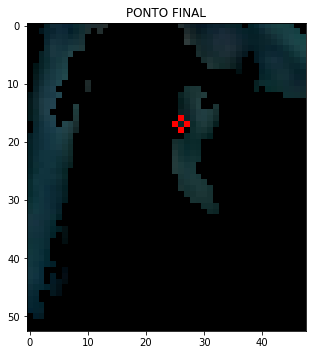

In [33]:
cv.circle(imgSegBGR, (pontoX,pontoY), 1, (255,0,0))

mostraImagem(imgSegBGR, "PONTO FINAL")

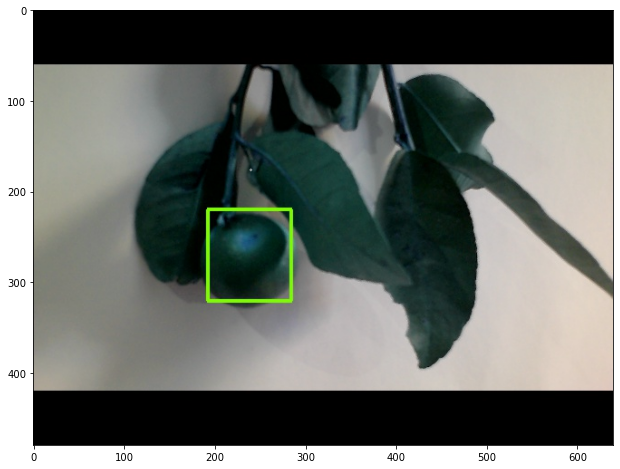

In [34]:
img = cv.imread(IMAGEM_CAPTURADA_NORMAL)

PontoFinalX = TopLeftX + pontoX
PontoFinalY = TopLeftY + pontoY

cv.circle(img, (PontoFinalX, PontoFinalY), 1, (255,255,255))

cv.imwrite("pedunculoEncontradoAritimetica" + idImagem + ".jpg", img)

fig = plt.figure(figsize = (20,8))
plt.imshow(img)
plt.show()

In [35]:
print("Coordenada de partida x,y:           {}".format(pontoPartida))
print("A quantidade de busca foram:         {}".format(contaBuscas))
#print("O tempo de busca foi:                {}".format(tempo))
print("As coordenadas pedunculo foram x,y:  ({},{})".format(pontoX, pontoY))
print("As coordenadas finais são: x,y:      ({},{})".format(PontoFinalX, PontoFinalY))
print("A precisão da cor encontrada foi de: {:.2f}%".format(acuraciaEncontrada))
print("O Erro Quadradico Médio é de:        {:.2f}".format(resultadoMSE))
print("A diferença Euclidiana é de:         {:.2f}".format(menorEuclidiana))

Coordenada de partida x,y:           (20, 20)
A quantidade de busca foram:         2
As coordenadas pedunculo foram x,y:  (26,17)
As coordenadas finais são: x,y:      (240,176)
A precisão da cor encontrada foi de: 86.59%
O Erro Quadradico Médio é de:        8.83
A diferença Euclidiana é de:         7.28
